### load finetuned model

In [1]:

from pathlib import Path
import torch
import sys
sys.path.append('..')
from mlm_utils.transform_func import encode_text
from utils.data_utils import NLP_MODELS
from utils.task_utils import TasksParam
from SRL.model import multiTaskModel
model_file = Path('/mnt/c/Users/Phat Pham/Documents/THESIS/SRLPredictionEasel/output/multi_task_model_9_13050.pt')


def load_params(model_file):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Load finetuned model 
    loadedDict = torch.load(model_file, map_location=torch.device(device))
    
    taskParams = loadedDict['task_params']
   
    allParams = {}
    allParams['task_params'] = taskParams
    allParams['gpu'] = torch.cuda.is_available()
    
    # dummy values
    allParams['num_train_steps'] = 10
    allParams['warmup_steps'] = 0
    allParams['learning_rate'] = 2e-05
    allParams['epsilon'] = 1e-8

    modelName = taskParams.modelType.name.lower()
    print("Model Name: ", modelName)
    # _, _ , tokenizerClass, defaultName = NLP_MODELS[modelName]
    # configName = taskParams.modelConfig
    # if configName is None:
    #     configName = defaultName

    return allParams, loadedDict

a = load_params(model_file)
model = multiTaskModel(a[0])
model.load_multi_task_model(a[1])

/home/phatpham/anaconda3/envs/min_ds-env/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2024-05-28 12:18:38.516488: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 12:18:38.672332: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 12:18:40.161298: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-28 12:18:41.613833: E tensorflow/compiler/xla/stream_executor/cuda/cu

Model Name:  bert


### get data mask


In [2]:

import numpy as np 
import pandas as pd
from data_preparation import * 
from mlm_utils.pertured_dataset import PerturedDataset
from mlm_utils.transform_func import get_files
import torch.nn as nn
import os
import torch
from utils.eval_metrics import seqeval_f1_score

In [3]:
import numpy as np
from sklearn.metrics import brier_score_loss
from sklearn.preprocessing import label_binarize


def brier_score_for_batch(y_true_b, y_prob_b, label_map):
    def brier_score_multi_class(y_true, y_prob, label_map=label_map):
        """
        Calculate the Brier score for multi-class classification using scikit-learn.

        Parameters:
        y_true (numpy.ndarray): True class labels, shape (n_samples,)
        y_prob (numpy.ndarray): Predicted probabilities, shape (n_samples, n_classes)

        Returns:
        float: Brier score
        """
        
        y_prob = np.array(y_prob, dtype=float)  # Predicted probabilities
        # Ensure y_true is a 1D array
        y_true = np.array(y_true)
        
        # label map 
        y_true = [label_map[item] for item in y_true]
        y_true_one_hot = label_binarize(y_true, classes=np.arange(y_prob.shape[1]))

        # Calculate the Brier score for each class and average them
        print()
        brier_scores = np.array([brier_score_loss(y_true_one_hot[:, i], y_prob[:, i], pos_label=1) for i in range(y_prob.shape[1])])
        return np.mean(brier_scores)

    brier_score_batch = list(map(brier_score_multi_class, y_true_b, y_prob_b))
    return np.mean(brier_score_batch)

In [4]:

class DataMaker():
    def __init__(self, data_file, eval_batch_size=32, max_seq_len=85, seed=42):
        self.data_file = data_file
        
        self.eval_batch_size = eval_batch_size
        self.max_seq_len = max_seq_len
        self.seed = seed
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        assert os.path.exists(self.data_file), "prediction tsv file not present at {}".format(self.data_file)
        
        self.dataset = PerturedDataset(self.data_file, self.device)
        self.dataloader = self.dataset.generate_batches(self.dataset, self.eval_batch_size)
       
    def get_predictions(self, model):
        model.network.eval()
        
        allPreds = []
        allScores = []
        allLogitsSoftmax = []
        allLogitsRaw = []
        allLabels = []
        allOriginUIDs = []
        for batch in tqdm(self.dataloader, total = len(self.dataloader)):
            batch = tuple(t.to(self.device) if isinstance(t, torch.Tensor) else t for t in batch)

            origin_uid, token_id, type_id, mask, label, pos_tag_id = batch
            with torch.no_grad():
                _, logits = model.network(token_id, type_id, mask, 0, 'conllsrl')

               
                outLogitsSoftmax = nn.functional.softmax(logits, dim = 2).data.cpu().numpy()
                
                outLogitsSigmoid = nn.functional.sigmoid(logits).data.cpu().numpy()
                
                predicted_sm = np.argmax(outLogitsSoftmax, axis = 2)
                

                # here in score, we only want to give out the score of the class of tag, which is maximum
                predScore = np.max(outLogitsSigmoid, axis = 2).tolist() 
                
                predicted_sm = predicted_sm.tolist()
                
                # get the attention masks, we need to discard the predictions made for extra padding
                
                predictedTags = []
                predScoreTags = []
                
                if mask is not None:
                    #shape of attention Masks (batchSize, maxSeqLen)
                    actualLengths = mask.cpu().numpy().sum(axis = 1).tolist()
                
                    for i, (pred, sc) in enumerate(zip(predicted_sm, predScore)):
                        predictedTags.append( pred[:actualLengths[i]] )
                        predScoreTags.append( sc[:actualLengths[i]])
        
                else:
                    predictedTags = predicted_sm
                    predScoreTags = predScore
                
                allPreds.append(predictedTags)  
                allScores.append(predScoreTags)  
                allLogitsSoftmax.append(outLogitsSoftmax)
                allLabels.append(label.tolist())
                allLogitsRaw.append(logits.data.cpu().numpy())
                allOriginUIDs.append(origin_uid)
            
        allOriginUIDs = [item for sublist in allOriginUIDs for item in sublist]
        allPreds = [item for sublist in allPreds for item in sublist]
        allScores = [item for sublist in allScores for item in sublist]
        allLogitsSoftmax = [item for sublist in allLogitsSoftmax for item in sublist]
        allLogitsRaw = [item for sublist in allLogitsRaw for item in sublist]
        allLabels = [item for sublist in allLabels for item in sublist]

        return allOriginUIDs, allPreds, allScores, allLogitsSoftmax, allLogitsRaw, allLabels

  
    
    def evaluate(self, model, labMapRevN, wrtPredPath=None, wrtDir=None, returnPreds=True, hasTrueLabels=True, needMetrics=True):
        allOriginUIDs, allPreds, allScores, allLogitsSoftmax, allLogitsRaw, allLabels = self.get_predictions(model)
        
        for j, (p, l) in enumerate(zip(allPreds, allLabels)):
            allLabels[j] = l[:len(p)]
            allPreds[j] = [labMapRevN[int(ele)] for ele in p]
            allLabels[j] = [labMapRevN[int(ele)] for ele in allLabels[j]]
        #allPreds[i] = [ [ labMapRev[int(p)] for p in pp ] for pp in allPreds[i] ]
        #allLabels[i] = [ [labMapRev[int(l)] for l in ll] for ll in allLabels[i] ]

        newPreds = []
        newLabels = []
        newScores = []
        newLogitsSoftmax = []
        
        labelMap = {v:k for k,v in labMapRevN.items()}
        for m, samp in enumerate(allLabels):
            Preds = []
            Labels = []
            Scores = []
            LogitsSm = []
            for n, ele in enumerate(samp):
                #print(ele)
                if ele != '[CLS]' and ele != '[SEP]' and ele != 'X':
                  
                    Preds.append(allPreds[m][n])
                    Labels.append(ele)
                    Scores.append(allScores[m][n])
                    LogitsSm.append(allLogitsSoftmax[m][n])
                    
            newPreds.append(Preds)
            newLabels.append(Labels)
            newScores.append(Scores)
            newLogitsSoftmax.append(LogitsSm)
        
        allLabels = newLabels
        allPreds = newPreds
        allScores = newScores    
        allLogitsSoftmax = newLogitsSoftmax        
        
        if needMetrics:
        
            print("**********Evaluation************\n")
            
            metricVal = brier_score_for_batch(allLabels, allLogitsSoftmax, labelMap)
            print("Brier Score: ", metricVal)
        
        # flatten allPreds, allScores
        if wrtPredPath is not None and wrtDir is not None:
            for i in range(len(allPreds)):
                if allPreds[i] == []:
                    continue
                if hasTrueLabels:
                    df = pd.DataFrame({"uid" : allOriginUIDs[i], "prediction" : allPreds[i], "label" : allLabels[i]})
                    savePath = os.path.join(wrtDir, "origin_{}".format(wrtPredPath))
                else:
                    df = pd.DataFrame({"uid" : allOriginUIDs[i], "prediction" : allPreds[i]})
                    savePath = os.path.join(wrtDir, "masked_{}".format(wrtPredPath))

            df.to_csv(savePath, sep = "\t", index = False)
        
        if returnPreds:
            return allOriginUIDs, allPreds, allScores, allLogitsSoftmax, allLogitsRaw, allLabels    

In [5]:
def get_word(dataDir, file_name, model, labelRn, wrtDir=None, hasTrueLabels=True, needMetrics=True):
    dataMaker = DataMaker(
        data_file= os.path.join(dataDir, file_name)
    )
    result = dataMaker.evaluate(model, labelRn, wrtPredPath=file_name, wrtDir=wrtDir, returnPreds=True, hasTrueLabels=hasTrueLabels, needMetrics=needMetrics)
    return {
        'uid': result[0],
        'pred': result[1],
        'score': result[2],
        'logitsSoftmax': result[3],
        'logitsRaw': result[4],
        'label': result[5] # masked word kh cos label
    }

In [5]:


def get_idx_arg_preds(preds_origin, preds_masked, label_origin=None): # label_origin: nhãn gold
    list_idx_arg_change = []
 
    
    for i in range(min(len(preds_masked), len(preds_origin))):
        test = preds_origin[i].startswith('B-A') or preds_origin[i].startswith('I-A') or preds_masked[i].startswith('B-A') or preds_masked[i].startswith('I-A')
        if label_origin:
            assert len(preds_origin) == len(label_origin), 'Length of preds_origin and label_origin must be the same'
            if test or label_origin[i].startswith('B-A') or label_origin[i].startswith('I-A'):
                list_idx_arg_change.append(i)
        else:
            if test:
                list_idx_arg_change.append(i)
   
    return list_idx_arg_change

def calculateInfluenceScore(outLogitsSigmoid_original, outLogitsSigmoid_meddle, list_arg_change):
    influence_score = []
    weight = []
    if len(list_arg_change) == 0:
        return influence_score, weight
    else:
        for i in range(min(len(outLogitsSigmoid_original), len(outLogitsSigmoid_meddle))):
            if i not in list_arg_change:
                continue
            max_index_original = np.argmax(outLogitsSigmoid_original[i])
        
            max_index_meddle = np.argmax(outLogitsSigmoid_meddle[i])
           
            if max_index_original == max_index_meddle:
              
                influence_score.append((outLogitsSigmoid_original[i][max_index_original] - outLogitsSigmoid_meddle[i][max_index_meddle]) / max(outLogitsSigmoid_original[i][max_index_original], outLogitsSigmoid_meddle[i][max_index_meddle]))
                weight.append(1)
            else:
               
                influ_old_label = (outLogitsSigmoid_original[i][max_index_original] - outLogitsSigmoid_meddle[i][max_index_original]) / max(outLogitsSigmoid_original[i][max_index_original], outLogitsSigmoid_meddle[i][max_index_original])
                influ_new_label = (outLogitsSigmoid_meddle[i][max_index_meddle] - outLogitsSigmoid_original[i][max_index_meddle]) / max(outLogitsSigmoid_original[i][max_index_meddle], outLogitsSigmoid_meddle[i][max_index_meddle])
                influence_score.append(influ_old_label + influ_new_label)
                weight.append(2)
    return influence_score, weight

In [6]:


def relevance_score(prob_origin_, prob_masked_, labMap, label_gold, label_origin, label_masked):
    relevance = []
    weight = []
    jud_space = get_idx_arg_preds(label_origin, label_masked, label_gold)
    
    for i in range(len(prob_origin_)):
        if i not in jud_space:
            continue
        # print(i)
        max_index_origin = np.argmax(prob_origin_[i])
        max_index_masked = np.argmax(prob_masked_[i])
       
        idx_label_gold = labMap[str(label_gold[i])]
        
        # idx_label_gold = label_gold[i]
        if label_gold[i] == label_origin[i] and label_gold[i] == label_masked[i]:
            score_increase_gold = (prob_origin_[i][idx_label_gold] - prob_masked_[i][idx_label_gold])/max(prob_origin_[i][idx_label_gold], prob_masked_[i][idx_label_gold])
            relevance.append(score_increase_gold)
            weight.append(1)
            # print(score_increase_gold)
        elif label_masked[i] != label_origin[i] and label_origin[i] == label_gold[i]:
            score_increase_gold = (prob_origin_[i][idx_label_gold] - prob_masked_[i][idx_label_gold])/max(prob_origin_[i][idx_label_gold], prob_masked_[i][idx_label_gold])
            score_decrease_mask = (prob_masked_[i][max_index_masked] - prob_origin_[i][max_index_masked])/max(prob_masked_[i][max_index_masked], prob_origin_[i][max_index_masked])
            relevance.append((score_increase_gold + score_decrease_mask)/2)
            weight.append(2)
            # print(score_increase_gold, score_decrease_mask)
        elif label_origin[i] != label_masked[i] and label_masked[i] == label_gold[i]:
            score_increase_gold = (prob_origin_[i][idx_label_gold] - prob_masked_[i][idx_label_gold])/max(prob_origin_[i][idx_label_gold], prob_masked_[i][idx_label_gold])
            score_decrease_origin = (prob_masked_[i][max_index_origin] - prob_origin_[i][max_index_origin])/max(prob_masked_[i][max_index_origin], prob_origin_[i][max_index_origin])
            relevance.append((score_increase_gold + score_decrease_origin)/2)
            weight.append(2)
            # print(score_increase_gold, score_decrease_origin)
        elif label_gold[i] != label_origin[i] and label_masked[i] != label_gold[i]:
            score_increase_gold = (prob_origin_[i][idx_label_gold] - prob_masked_[i][idx_label_gold])/max(prob_origin_[i][idx_label_gold], prob_masked_[i][idx_label_gold])
            score_decrease_mask = (prob_masked_[i][max_index_masked] - prob_origin_[i][max_index_masked])/max(prob_masked_[i][max_index_masked], prob_origin_[i][max_index_masked])
            score_decrease_origin = (prob_masked_[i][max_index_origin] - prob_origin_[i][max_index_origin])/max(prob_masked_[i][max_index_origin], prob_origin_[i][max_index_origin])
            relevance.append((score_increase_gold + score_decrease_mask + score_decrease_origin)/3)
            weight.append(1)
            # print(score_increase_gold, score_decrease_mask, score_decrease_origin)
        
        # print('------------------------')
    return relevance, weight

In [7]:
def check_arg_change(preds_masked, label):
    assert len(preds_masked) == len(label), 'Length of preds_masked and label must be the same'
    changed_args = set()
    # check if preds_masked is different from label, then save the value of label. Remember save the unique value
    for i in range(len(preds_masked)):
        if preds_masked[i] != label[i] and (label[i].startswith('B-A') or label[i].startswith('I-A')):
            if (label[i].startswith('B-A') or label[i].startswith('I-A')):
                changed_args.add(label[i].split('-')[-1])
            
    return changed_args    
        

def competence_score(origin, masked, labelMap):
  
    jump_count = 0
    comp_dict = {}
    for i in range(len(origin['uid'])):
        for j in range(jump_count, len(masked['uid'])):
            if int(origin['uid'][i]) == int(masked['uid'][j]):
                changed_args = check_arg_change(masked['pred'][j], masked['label'][j])
                
                influenceScore, weight_influ = calculateInfluenceScore(origin['logitsSoftmax'][i], masked['logitsSoftmax'][j], get_idx_arg_preds(origin['pred'][i], masked['pred'][j]))
                relevance_in_all_words, weight_relevance = relevance_score(origin['logitsSoftmax'][i], masked['logitsSoftmax'][j],labelMap, origin['label'][i], origin['pred'][i], masked['pred'][j])
                
                score = {
                        'uid': origin['uid'][i],
                        'influence': sum(influenceScore) / sum(weight_influ) if sum(weight_influ) != 0 else 0,
                        'relevance': sum(relevance_in_all_words) / sum(weight_relevance) if sum(weight_relevance) != 0 else 0
                        }
                
                # save to comp_dict with key is item in changed_args, value is score
                for arg in changed_args:
                    if arg not in comp_dict:
                        comp_dict[arg] = []
                    comp_dict[arg].append(score)
            
        
    return comp_dict

In [8]:
from scipy.stats import spearmanr, permutation_test
def get_spearmanr(comp):
    influence_values = [abs(item['influence']) for item in comp]
    relevance_values = [item['relevance'] for item in comp]

    # Calculate Spearman correlation
    correlation_coefficient, p_value = spearmanr(influence_values, relevance_values)

    return correlation_coefficient, p_value

In [12]:

def get_comp(dataMaskedDir, dataOriginDir, model, labelRn, logger, wrtDir=None):
    file_mask = get_files(dataMaskedDir)
 
    file_origin = get_files(dataOriginDir) 
   
    for mask, origin in zip(file_mask, file_origin):
        logger.info("Calculate file {} and {}".format(mask, origin))
        resultwordMasked = get_word(dataMaskedDir, mask, model, labelRn, hasTrueLabels=False, needMetrics=False)
        resultOrigin = get_word(dataOriginDir, origin, model, labelRn, wrtDir=wrtDir, hasTrueLabels=True, needMetrics=False)

        labelMap = {v: k for k, v in labelRn.items()}
        comp_score = competence_score(resultOrigin, resultwordMasked, labelMap)
        # print number of items in each key
        
        for key, value in comp_score.items():
            logger.info("key: {} has {} items, spearrman {} with p-value {}.".format(key, len(value), get_spearmanr(value)[0], get_spearmanr(value)[1]))
       
        print("-------------------------------------------------")
       

In [6]:
labelMap = a[0]['task_params'].labelMap['conllsrl']
labelRn = {v:k for k,v in labelMap.items()}


In [7]:
from datetime import datetime
from logger_ import make_logger

#setting logging
now = datetime.now()
logDir = now.strftime("%d_%m-%H_%M")
if not os.path.isdir(logDir):
    os.makedirs(logDir)

logger = make_logger(name = "cal_comp_by_arg", debugMode=True,
                    logFile=os.path.join(logDir, 'cal_comp_logs.log'), silent=True)
logger.info("logger created.")

dataMaskedDir = Path('/mnt/c/Users/Phat Pham/Documents/THESIS/SRLPredictionEasel/MLM/data_mlm/perturbed_data/avg_neg_cos_old_label/')

dataOriginDir =  Path('/mnt/c/Users/Phat Pham/Documents/THESIS/SRLPredictionEasel/MLM/data_mlm/process_folder/coNLL_tsv_json/label_cu')
get_comp(dataMaskedDir, dataOriginDir, model, labelRn, logger, wrtDir=None)

NameError: name 'get_comp' is not defined

In [8]:
dataOriginDir = Path('/mnt/c/Users/Phat Pham/Documents/THESIS/SRLPredictionEasel/MLM/data_mlm/process_folder/coNLL_tsv_json/label_cu')
origin = Path('ner_conll_format_develop_full.json')
resultOrigin = get_word(dataOriginDir, origin, model, labelRn, wrtDir=None, hasTrueLabels=True, needMetrics=False)

100%|██████████| 6/6 [00:31<00:00,  5.32s/it]


: 

In [19]:
# Calculate the Brier score
brier_score = brier_score_for_batch(resultOrigin['label'], resultOrigin['logitsSoftmax'], labelMap)
print(f"Brier Score: {brier_score}")

Brier Score: 0.03144675279935072


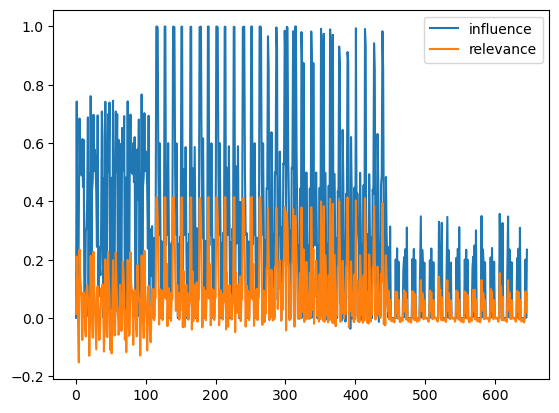

In [ ]:
# # visualize the influence and relevance score
# import matplotlib.pyplot as plt


# influence = [item['influence'] for item in competence]
# relevance = [item['relevance'] for item in competence]

# # line chart
# plt.plot(influence, label='influence')
# plt.plot(relevance, label='relevance')
# plt.legend()
# plt.show()